In [215]:
from climada.hazard.base import Hazard
from climada.hazard.low_flow import LowFlow
from climada.entity import ImpactFunc, ImpactFuncSet
from climada.entity.exposures import Exposures
from climada.engine import Impact
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import fiona
import datetime
import geopandas as gpd
from climada.util.coordinates import dist_to_coast

In [216]:
wri_power_plants_path = 'power_plants_wri/global_power_plant_database.csv'


def load_exposure(bbox=[-180, -90, 180, 90], exp_path=wri_power_plants_path, primary_fuel='Nuclear'):
    """load exposure data from CSV
    Here, we use WRI power plant data from
    https://www.wri.org/publication/global-power-plant-database"""
    exp_df = pd.read_csv(exp_path)
    if primary_fuel:
        exp_df = exp_df[exp_df.primary_fuel==primary_fuel]
    # europe:
    exp_df = exp_df[exp_df.longitude>bbox[0]]
    exp_df = exp_df[exp_df.longitude<bbox[2]]
    exp_df = exp_df[exp_df.latitude>bbox[1]]
    exp_df = exp_df[exp_df.latitude<bbox[3]]
    exp_df['gen_mean']=exp_df[["generation_gwh_2013", "generation_gwh_2014", "generation_gwh_2015", "generation_gwh_2016", "generation_gwh_2017"]].mean(axis=1)
    exp_df['value']=exp_df[["gen_mean", "estimated_generation_gwh"]].mean(axis=1)
    # exp_df['value'] = exp_df.capacity_mw # provide value in MegaWatt
    
    #exp_df['latitude'] = 
    #exp_df['longitude'] = 
    exp_df['if_'] = 1
    exp_df['if_LF'] = 1
    # exp_df = exp_df.drop(columns=['country', 'name', 'gppd_idnr',
    #    'latitude', 'longitude', 'primary_fuel', 'owner', 'source', 'url',
    #    'geolocation_source', 'wepp_id', 'year_of_capacity_data',
    #    'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
    #    'generation_gwh_2016', 'generation_gwh_2017',
    #    'estimated_generation_gwh', 'value', 'value_unit', 'if_TC', 'geometry'])
    

    # Generate Exposures from exposure-DataFranme
    exp_df = Exposures(exp_df)
    exp_df.value_unit = 'GWh'
    exp_df.ref_year = 2005
    exp_df.set_geometry_points() # set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
    print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')
    exp_df.check() # puts metadata that has not been assigned
    return exp_df

In [ ]:
nuclear_exp = load_exposure(primary_fuel='Nuclear')
coal_exp = load_exposure(primary_fuel='Coal')
gas_exp = load_exposure(primary_fuel='Gas')
hydro_exp = load_exposure(primary_fuel='Hydro')


In [236]:
sum([len(nuclear_exp),len(coal_exp),len(gas_exp),len(hydro_exp)])

13665

# Getting rid of exposures far from rivers and to close to the coast
### The threshold is found visually by looking at maps of rivers and power plants. 
### We also aim for a ratio of about 50% of nuclear power plants remaining and would also want 100%  of hydro power plants remaining

In [218]:
# this data is built ith different layers from quantiles of river size, a few layers where needed to reach
# a sufficient level of detail
# https://www.bafg.de/GRDC/EN/Home/homepage_node.html

rivers1 = gpd.read_file('../low_flow/rivers/mrb_rivnets_Q09_10.shp')
rivers2 = gpd.read_file('../low_flow/rivers/mrb_rivnets_Q08_09.shp')
rivers3 = gpd.read_file('../low_flow/rivers/mrb_rivnets_Q07_08.shp')
rivers4 = gpd.read_file('../low_flow/rivers/mrb_rivnets_Q06_07.shp')
rivers5 = gpd.read_file('../low_flow/rivers/mrb_rivnets_Q05_06.shp')
rivers6 = gpd.read_file('../low_flow/rivers/mrb_rivnets_Q04_05.shp')



In [219]:
rivers1.head()

,RIVER_BASI,CONTINENT,OCEAN,SEA,AREA_CALC,Shape_Leng,MRBID,geometry
0,ATOUI,Africa,Atlantic Ocean,North Atlantic,27695.3,4.092204,1201,LINESTRING (-14.00208333333333 22.202083333332...
1,BANDAMA,Africa,Atlantic Ocean,Gulf of Guinea,99253.9,13.885620,1202,(LINESTRING (-4.827083333333519 5.947916666666...
2,BIA,Africa,Atlantic Ocean,Gulf of Guinea,10957.0,1.051965,1203,LINESTRING (-3.227083333333525 6.0187499999993...
3,CAVALLY,Africa,Atlantic Ocean,Gulf of Guinea,29622.7,3.372281,1204,LINESTRING (-7.943750000000165 6.2979166666660...
4,CESTOS (also NUON),Africa,Atlantic Ocean,North Atlantic,12785.1,1.435313,1205,LINESTRING (-8.839583333333422 6.0979166666660...


In [220]:
rivers = [rivers1, rivers2, rivers3, rivers4, rivers5, rivers6]
sum(len(r) for r in rivers)

3062

In [221]:
def min_distance(point, lines):
    return lines.distance(point).min()

In [222]:
def filter_exposures(exposures, layers, min_dist_coast, max_dist_rivers, rivers=rivers):
    #dist to coast in m
    #dist to rivers in degrees
    exposures_filtered = exposures.copy()
    for n in range(layers):
        exposures_filtered["".join(['min_dist_to_lines',str(n)])] = exposures.geometry.apply(min_distance, args=(rivers[n],))
    exposures_filtered['min_dist_to_lines'] = exposures_filtered.loc[:,exposures_filtered.columns.str.contains('dist_to', case=False)].min(axis=1)
    exposures_filtered = exposures_filtered[(exposures_filtered['min_dist_to_lines']<max_dist_rivers)]
    exposures_filtered = Exposures(exposures_filtered)
    exposures_filtered.crs = {'init': 'epsg:4326'}
    exposures_filtered['dist_to_coast'] = dist_to_coast(exposures_filtered) #get the distance to coast 
    exposures_filtered = exposures_filtered[exposures_filtered['dist_to_coast']>min_dist_coast] # dist to coast is in meters  
#    exposures = exposures.loc[:, ~exposures.columns.str.contains('dist_to', case=False)]
    return exposures_filtered
    

In [ ]:
for n in range(5):
    nuclear_close_to_rivers = filter_exposures(nuclear_exp, n+1, 100, 0.1)  
    print(n+1)
    print(len(nuclear_close_to_rivers)/len(nuclear_exp))

In [ ]:
nuclear_close_to_rivers = filter_exposures(nuclear_exp, 4, 100, 0.1)

In [ ]:
print(len(nuclear_close_to_rivers)/len(nuclear_exp))

### a few are removed while we do not expect them to be. But the ratio is in the range that we expect. Adding layers doesn't seem to really increase the quality. lacking rivers appear to be the main issue, but this is the most precise data I could find

In [225]:
def plot_exposures_map_pp(rivers, exposures, exposures_filtered, label, xlim, ylim):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = rivers[0].plot(figsize=(15,10), linewidth=0.5,alpha=0.5)
    world.boundary.plot(ax=ax,color='Black', linewidth=0.5,alpha=0.5)
    for r in rivers[1:]:
        r.plot(linewidth=0.5,ax=ax,alpha=0.5)
    exposures.plot(ax=ax,color='Red',markersize=40,label=label,marker='x')
    exposures_filtered.plot(ax=ax,markersize=40,label="".join([label,' Remaining']),marker='x',color='Black')

    ax.legend()
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_title("".join([label, ' Power Plants']))    

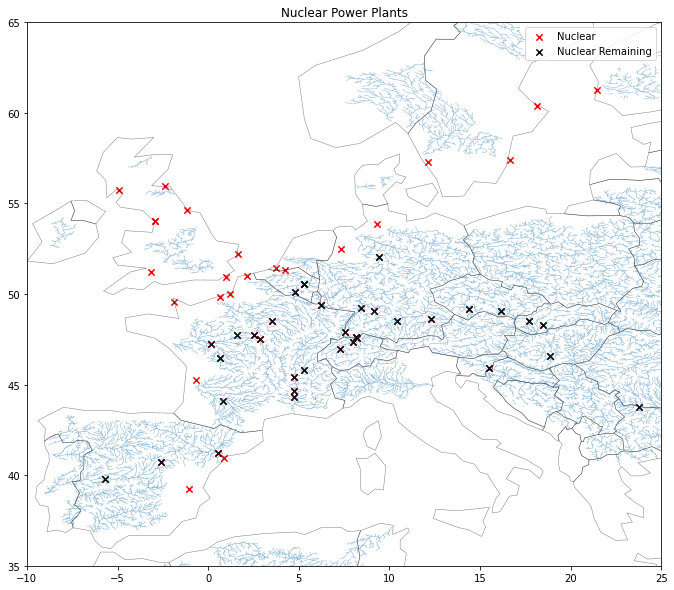

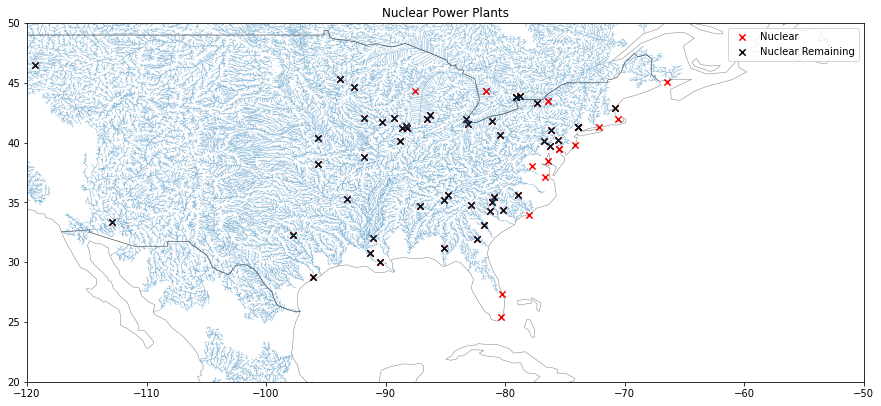

In [226]:
plot_exposures_map_pp(rivers, nuclear_exp, nuclear_close_to_rivers, 'Nuclear', [-10, 25], [35, 65])
plot_exposures_map_pp(rivers, nuclear_exp, nuclear_close_to_rivers, 'Nuclear', [-120, -50], [20, 50])

### We definetly would expect a river in the south of spain near that point, but it doesn't seem to appear even by adding additional layers, same goes for northern germany

In [ ]:
gas_close_to_rivers = filter_exposures(gas_exp, 4, 100, 0.1)

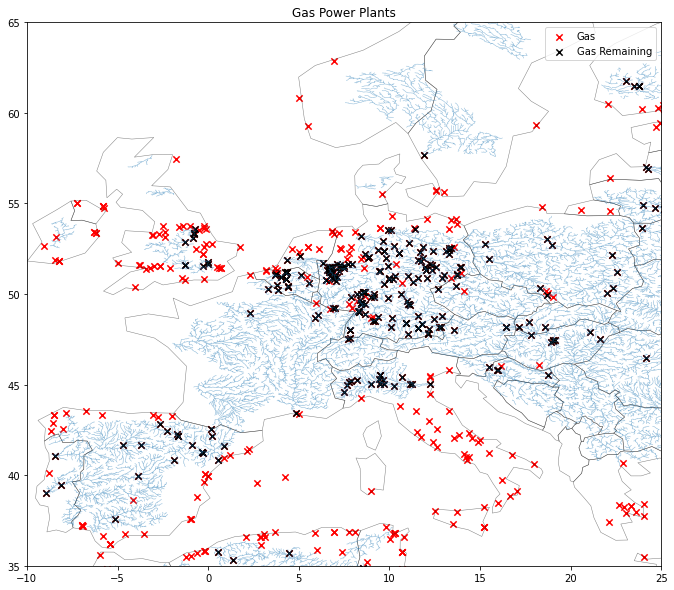

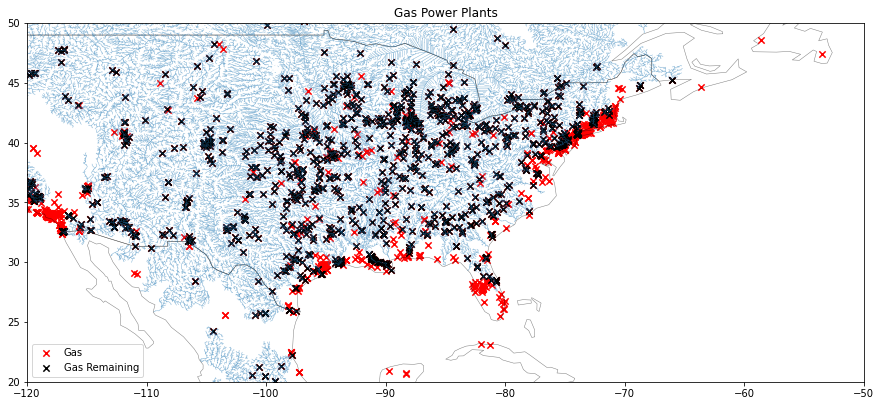

In [234]:
plot_exposures_map_pp(rivers, gas_exp, gas_close_to_rivers, 'Gas', [-10, 25], [35, 65])
plot_exposures_map_pp(rivers, gas_exp, gas_close_to_rivers, 'Gas', [-120, -50], [20, 50])

In [228]:
print(len(gas_close_to_rivers)/len(gas_exp))

0.5418154003059663


### what portion of gas pp are close to rivers in israel? We know that almost none should be cooled by rivers

In [229]:
len(gas_close_to_rivers[gas_close_to_rivers['country_long']=='Israel'])/len(gas_exp[gas_exp['country_long']=='Israel'])

0.05555555555555555

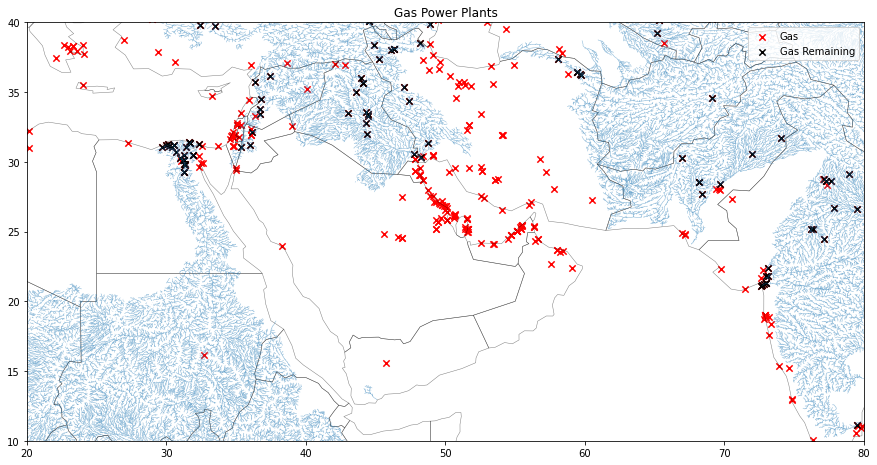

In [230]:
plot_exposures_map_pp(rivers, gas_exp, gas_close_to_rivers, 'Gas', [20, 80], [10, 40])

In [231]:
len(gas_exp[gas_exp['country_long']=='Israel'])

18

In [ ]:
#coal_close_to_rivers.to_excel('coal_exposures.xlsx')
gas_close_to_rivers.to_excel('exposures/gas_exposures.xlsx')
nuclear_close_to_rivers.to_excel('exposures/nuclear_exposures.xlsx')
hydro_exp.to_excel('exposures/hydro_exposures.xlsx')